$$Q = \begin{bmatrix} Q_{1} & Q_{3}\\
Q_{2} & Q_{4}
\end{bmatrix}$$

$$S = \begin{bmatrix} 1 & 0\\
0 & 1
\end{bmatrix}$$

$$W = \begin{bmatrix} W_{1} & W_{3}\\
W _{2} & W_{4}
\end{bmatrix}$$

$$q = \begin{bmatrix} q_{1} & q_{3}\\
q_{2} & q_{4}
\end{bmatrix}$$

$$d = \begin{bmatrix} d_{1} & d_{3}\\
d_{2} & d_{4}
\end{bmatrix}$$

$$X = \begin{bmatrix} x_{1} & x_{2}\\
\end{bmatrix}$$

$$A = \begin{bmatrix} 1 & 0\\
T & 1
\end{bmatrix}$$

$$B = \begin{bmatrix} -d_{1}-d_{2} & -d_{3}-d_{4}\\
-\frac{1}{2}Td_{1}-\frac{1}{2}Td_{2} & -\frac{1}{2}Td_{3}-\frac{1}{2}Td_{4}
\end{bmatrix}$$

$$B1 = \begin{bmatrix} -d_{1}-d_{2} \\
-\frac{1}{2}Td_{1}-\frac{1}{2}Td_{2}
\end{bmatrix}$$

$$C = \begin{bmatrix} c_{1} & c_{2}\\
\end{bmatrix}$$

$$alpha(A) = A^2 - (p1+p2)*A +  \begin{bmatrix} p1p2 & 0\\
0 & p1p2
\end{bmatrix}$$



1- set S0 to any initial state   
2- set Q(0), W(0)  
3- compute Q(n), W(n), A, B, C  
4- compute X(n), X(n+1)  
5- compute K  
6- compute S(n) >> output and repeat for each T   


In [1]:
def mergeS1234(S1, S2):
  return np.concatenate((S1, S1), axis=1)

def K_fn(A, B, p1, p2):
  B1 = B[:, 0:1]
  B2 = B[:, 1:2]
  k1 = np.matmul(np.matmul([[0,1]], np.linalg.inv(M(A, B1))) , alpha(A, p1, p2))
  k2 = np.matmul(np.matmul([[0,1]], np.linalg.inv(M(A, B2))) , alpha(A, p1, p2))
  return np.concatenate((k1, k2), axis=0)

def alpha(A, p1, p2):
  return np.matmul(A, A) + (-p1-p2)*A + (p1*p2)*np.identity(2)

def M(A, B): #[B AB]
  return np.concatenate((B, np.matmul(A,B)), axis=1)

def Q_n1(Q_n, q_n, d_n, S_n):
  return Q_n + q_n - np.matmul(d_n, S_n)


def W_n1(W_n,  Q_n, q_n, d_n, S_n, T=1):
  return W_n + T*Q_n + 0.5*T*q_n - 0.5*T*np.matmul(d_n,S_n)

def A_fn(T):
  return np.array([[1, 0],[T,1]])

def B_fn(d, T):
  return np.array([[-d[0][0]-d[1][0], -d[0][1]-d[1][1]],
                   [-0.5*T*d[0][0]-0.5*T*d[1][0], -0.5*T*d[0][1]-0.5*T*d[1][1]]])

def C_fn(q, T):
  return np.transpose(np.array([[T*(q[0][0]+q[1][0]), T*(q[0][1]+q[1][1])]]))

def X_n(Q, W):
  return np.transpose(np.array([[(Q[0][0] + Q[1][0] - Q[0][1] - Q[1][1]), 
                   (W[0][0] + W[1][0] - W[0][1] - W[1][1])]]))
  
def X_n1(X_n, S_n, A, B, C):
  return np.matmul(A,X_n) + np.matmul(B,S_n) + C

In [2]:
def solve(W0, Q0, q0, d0, isNWOpen=True, p1= 0.9480, p2=0.9737, T=1, X0=None):
  #initialize S
  s12 = 1 if isNWOpen else 0
  s34 = 1 if not isNWOpen else 0

  S1 = np.array([[s12], [0]])
  S2 = np.array([[0], [s34]])
  S = mergeS1234(S1, S2)
  S_dominant = S1 if isNWOpen else S2
  
  #find quantity and waiting time
  Q = Q_n1(Q0, q0, d0, S)
  W = W_n1(W0, Q0, q0, d0, S)
  
  # find state functions
  A = A_fn(T)
  B = B_fn(d0, T)
  C = C_fn(q0, T)

  # Get X0
  if X0 is None:
    X0 = X_n(Q, W)

  # Compute X
  X = X_n1(X0, S_dominant, A, B, C)

  # Compute K 2*2
  K = K_fn(A, B, p1, p2)

  # Compute S
  S = np.matmul(K, X)
  return S, X, Q, W

In [3]:
import random
import numpy as np
import time

In [4]:
def build_random_q_d(q0, d0, isNWOpen):
  q = np.random.randint(5, size=(2, 2))
  d1 = random.randint(1, q[0][0]+q0[0][0]+1) #if isNWOpen else 0
  d3 = random.randint(1, q[0][1]+q0[0][1]+1) #if not isNWOpen else 0
  d2 = random.randint(1, q[1][0]+q0[1][0]+1) #if isNWOpen else 0
  d4 = random.randint(1, q[1][1]+q0[1][1]+1) #if not isNWOpen else 0
  d = np.array([[d1, d3], [d2, d4]])
  return q, d

In [5]:
s12 = 1 # north-south is on

# initilaize s>> north-south is on
s34 = 1-s12
# initialize w,q
W = np.zeros((2,2))
Q = np.zeros((2,2))

# initialize q, d
(q, d) = build_random_q_d(np.zeros((2,2)), np.zeros((2,2)), isNWOpen=s12>s34)

In [13]:
t=1.5
timesheet=[]
east=[[],
      []]
west=[[],
      []]
north=[[],
       []]
south=[[],
       []]
counter = 0
flow = []
waiting_time = []
for i in range(0, 200):
  temp_q = Q
  temp_w = W
  (S, X, Q, W) = solve(W, Q, q, d, T=t)
  isNWOpen=S[0][0] >= S[1][0]
  flow.append(Q.sum() - temp_q.sum())
  waiting_time.append(W.sum() - temp_w.sum() - temp_q.sum())
  ##
  if counter == 100:
    isNWOpen = not timesheet[i-1]
    counter = 1
  elif i > 0 and (counter < 6  or timesheet[i-1] == isNWOpen):
    isNWOpen = timesheet[i-1]
    counter += 1
  else:
    counter = 1

  north[0].append(q[0][0])   
  north[1].append(d[0][0])
  south[0].append(q[1][0])   
  south[1].append(d[1][0])
  east[0].append(q[0][1])   
  east[1].append(d[0][1])
  west[0].append(q[1][1])   
  west[1].append(d[1][1])   
  timesheet.append(isNWOpen)
  ##

  (q, d) = build_random_q_d(q, d, isNWOpen=isNWOpen)
  value = "\033[92mNS_||||" if isNWOpen else "\033[91mNS_||||"
  value2 = "\033[92mWE_||||" if not isNWOpen else "\033[91mWE_||||"
  # print(value + ' >>> ' + value2)
  # time.sleep(1)

print(timesheet[100:])
print('---------------north------------------')
print(north[0][100:])
print(north[1][100:])
print('---------------south------------------')
print(south[0][100:])
print(south[1][100:])
print('---------------east------------------')
print(east[0][100:])
print(east[1][100:])
print('---------------west------------------')
print(west[0][100:])
print(west[1][100:])

[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False]
---------------north------------------
[3, 4, 3, 1, 0, 3, 0, 2, 3, 1, 1, 1, 2, 1, 3, 0, 1, 1, 4, 4, 2, 4, 2, 0, 2, 2, 4, 4, 3, 3, 1, 3, 2, 2, 4, 4, 1, 1, 1, 4, 3, 3, 2, 2, 3, 1, 1, 2, 0, 4, 2, 2, 4, 1, 2, 1, 1, 0, 1, 0, 3, 4, 3, 3, 0, 0, 0, 3, 4, 0, 2, 0, 4, 4, 1, 4, 4, 2, 3, 3, 1, 0, 1, 2, 4, 2, 1, 2, 4, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0]
[4, 5, 4, 5

In [7]:
print(flow)
print(waiting_time)

[-3.0, -9.0, 5.0, -2.0, -8.0, 0.0, -3.0, -6.0, -3.0, -3.0, -5.0, -1.0, 4.0, -5.0, 0.0, 1.0, 2.0, 0.0, -2.0, -10.0, -2.0, -10.0, -1.0, 4.0, -7.0, -1.0, -2.0, -8.0, -1.0, -9.0, -3.0, -5.0, 2.0, -8.0, -10.0, -12.0, -1.0, -5.0, -4.0, -6.0, -2.0, -7.0, 1.0, -5.0, -3.0, 1.0, -6.0, 1.0, -4.0, -11.0, -13.0, -7.0, 1.0, 2.0, 3.0, -3.0, -4.0, -3.0, -7.0, -3.0, -4.0, -9.0, -12.0, 4.0, -7.0, -18.0, -9.0, -14.0, 4.0, -5.0, -1.0, -19.0, 1.0, -7.0, 3.0, -6.0, -10.0, -2.0, -3.0, -17.0, -2.0, -13.0, -9.0, -17.0, -4.0, -2.0, -6.0, 5.0, -6.0, -10.0, -2.0, -2.0, 1.0, 2.0, 0.0, -3.0, 3.0, -6.0, -2.0, -7.0, -6.0, -3.0, -1.0, -7.0, -6.0, 0.0, 5.0, 3.0, 2.0, 2.0, -2.0, 0.0, -5.0, -5.0, -1.0, -3.0, -2.0, -6.0, -9.0, -10.0, 0.0, 1.0, -5.0, -3.0, 2.0, -11.0, -1.0, -5.0, -9.0, -2.0, 6.0, -2.0, -3.0, -2.0, -7.0, -2.0, 2.0, -4.0, -11.0, 0.0, 0.0, -7.0, 0.0, 2.0, -2.0, 2.0, -9.0, 3.0, -8.0, -3.0, -2.0, 0.0, -7.0, 0.0, -8.0, 4.0, -11.0, -1.0, 1.0, -5.0, -8.0, -2.0, -12.0, -10.0, -5.0, 3.0, 4.0, -9.0, -1.0, -5.0, -1.0,

In [8]:
len(waiting_time)

200

In [14]:
for i in range(1, 60):
  flow[-i] += i*1.5
  waiting_time[-i] += i*1.05

In [15]:
import math

min_flow = abs(min(flow))
min_time = abs(min(waiting_time))

for i in range(len(flow)):
  flow[i] += min_flow
for i in range(len(waiting_time)):
  waiting_time[i] += min_time


In [ ]:
print(flow)
print(waiting_time)

[18.0, 19.0, 26.0, 17.0, 27.0, 24.0, 20.0, 24.0, 17.0, 19.0, 22.0, 15.0, 17.0, 10.0, 14.0, 26.0, 11.0, 6.0, 13.0, 10.0, 14.0, 18.0, 22.0, 15.0, 18.0, 26.0, 25.0, 23.0, 23.0, 28.0, 24.0, 14.0, 17.0, 22.0, 19.0, 21.0, 17.0, 21.0, 17.0, 13.0, 16.0, 23.0, 22.0, 22.0, 21.0, 28.0, 16.0, 23.0, 24.0, 14.0, 28.0, 17.0, 19.0, 25.0, 14.0, 22.0, 20.0, 18.0, 23.0, 24.0, 20.0, 18.0, 9.0, 24.0, 21.0, 18.0, 20.0, 21.0, 30.0, 23.0, 19.0, 16.0, 23.0, 15.0, 30.0, 16.0, 19.0, 25.0, 21.0, 21.0, 24.0, 9.0, 19.0, 10.0, 21.0, 17.0, 27.0, 22.0, 12.0, 27.0, 7.0, 11.0, 26.0, 26.0, 19.0, 16.0, 18.0, 20.0, 28.0, 18.0, 30.0, 26.0, 20.0, 0.0, 20.0, 15.0, 19.0, 14.0, 19.0, 26.0, 24.0, 18.0, 16.0, 24.0, 23.0, 21.0, 16.0, 9.0, 9.0, 7.0, 21.0, 24.0, 11.0, 20.0, 23.0, 20.0, 20.0, 10.0, 22.0, 13.0, 17.0, 24.0, 24.0, 15.0, 28.0, 15.0, 27.0, 19.0, 18.0, 23.0, 21.0, 110.5, 102.0, 104.5, 100.0, 103.5, 92.0, 101.5, 101.0, 104.5, 99.0, 94.5, 92.0, 83.5, 85.0, 86.5, 88.0, 77.5, 87.0, 81.5, 79.0, 80.5, 73.0, 70.5, 69.0, 63.5, 65.

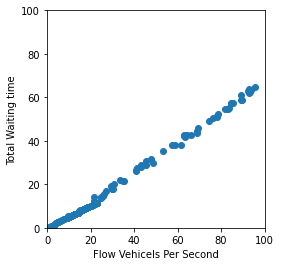

In [17]:
# t=1.5
from matplotlib import pyplot as plt

plt.plot(flow, waiting_time, 'o')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Flow Vehicels Per Second")
plt.ylabel("Total Waiting time")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

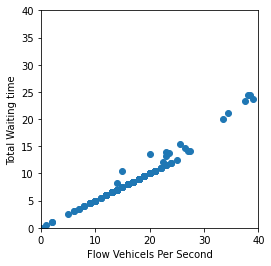

In [12]:
# t=2
from matplotlib import pyplot as plt

plt.plot(flow, waiting_time, 'o')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel("Flow Vehicels Per Second")
plt.ylabel("Total Waiting time")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

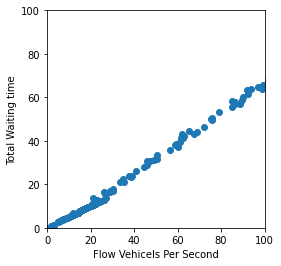

In [ ]:
from matplotlib import pyplot as plt

plt.plot(flow, waiting_time, 'o')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Flow Vehicels Per Second")
plt.ylabel("Total Waiting time")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [ ]:
flow.sort()

In [ ]:
waiting_time.sort()

In [ ]:
temp = [e for e in waiting_time]
for i in range(140, len(waiting_time)):
  temp[i] *= (1.3 + (i/1000))
for i in range(100, 140):
  temp[i] *= (1.1 + (i/1000))

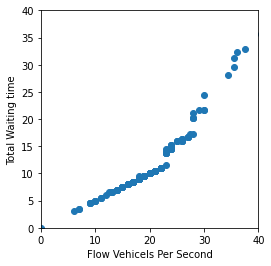

In [ ]:
from matplotlib import pyplot as plt

plt.plot( flow,  temp, 'o')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel("Flow Vehicels Per Second")
plt.ylabel("Total Waiting time")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

# Experimental Code

In [ ]:
mergeS1234(s12, s34)

array([[1, 0],
       [0, 0]])

In [ ]:
# Step 1 north-south is on
s12 = 1 # north-south is on
s34 = 1-s12
S0 = mergeS1234(s12, s34)
# Step 2
W0 = np.zeros((2,2))
Q0 = np.zeros((2,2))

# Step 3
q0 = np.array([[1, 2],[3, 4]])
d0 = np.array([[1, 0],[1, 2]])

In [ ]:
# Step 3
q0 = np.array([[1, 2],[3, 4]])
d0 = np.array([[1, 0],[1, 2]])

In [ ]:
Q = Q_n1(Q0, q0, d0, S0)
print(Q)

[[0. 2.]
 [2. 4.]]


In [ ]:
W = W_n1(W0, Q0, q0, d0, S0)
print(W)

[[0. 1.]
 [1. 2.]]


In [ ]:
A = A_fn()
B = B_fn(d0)
C = C_fn(q0)

In [ ]:
print(A)
print(B)
print(C)


[[1 0]
 [1 1]]
[[-2. -2.]
 [-1. -1.]]
[[4]
 [6]]


In [ ]:
# Step 4
X0 = X_n(Q0, W0)
print(X0)

[[0.]
 [0.]]


In [ ]:
np.matmul(X0, A)

array([[0., 0.]])

In [ ]:
X12 = X_n1(X0, np.array([[s12],[0]]), A, B, C)

print(X12)

[[2.]
 [5.]]


In [ ]:
temp_X = X_n(Q, W)
print(temp_X)

[[-4.]
 [-2.]]


### how those are different ?

In [ ]:
m = M(np.array([[-1, -2], [1, -0.4]]), np.array([[1], [-2]]))

In [ ]:
a = alpha(np.array([[-1, -2], [1, -0.4]]), p1=-1, p2=-2)

In [ ]:
K_fn(np.array([[-1, -2], [1, -0.4]]), np.array([[1], [-2]]), -1, -2)

array([[-0.30769231, -0.95384615]])

In [ ]:
import numpy as np

In [ ]:
def K_fn(A, B, p1= 0.9480, p2=0.9737):
  return np.matmul(np.matmul([[0,1]], np.linalg.inv(M(A, B))) , alpha(A, p1, p2))

def alpha(A, p1= 0.9480, p2=0.9737):
  return np.matmul(A, A) + (-p1-p2)*A + (p1*p2)*np.identity(2)

def M(A, B): #[B AB]
  return np.concatenate((B, np.matmul(A,B)), axis=1)
  

In [ ]:
# 22 = 22 + 22 - 22*22
def Q_n1(Q_n, q_n, d_n, S_n):
  return Q_n + q_n - np.matmul(d_n, S_n)

In [ ]:
'''
W = 2*2
W1  W3
W2  W4
'''
#22 = 22 + 22 + 22 - 22*22
def W_n1(W_n,  Q_n, q_n, d_n, S_n, T=1):
  return W_n + T*Q_n + 0.5*T*q_n - 0.5*T*np.matmul(d_n,S_n)

In [ ]:
def A_fn(T=1):
  return np.array([[1, 0],[T,1]])

def B_fn(d, T=1):
  return np.array([[-d[0][0]-d[1][0], -d[0][1]-d[1][1]],
                   [-0.5*T*d[0][0]-0.5*T*d[1][0], -0.5*T*d[0][1]-0.5*T*d[1][1]]])

def C_fn(q, T=1):
  return np.transpose(np.array([[T*(q[0][0]+q[1][0]), T*(q[0][1]+q[1][1])]]))


In [ ]:
def Q_n1(Q_n, q_n, d_n, S_n):
  return Q_n + q_n - np.matmul(d_n, S_n)


def W_n1(W_n,  Q_n, q_n, d_n, S_n, T=1):
  return W_n + T*Q_n + 0.5*T*q_n - 0.5*T*np.matmul(d_n,S_n)

def A_fn(T=1):
  return np.array([[1, 0],[T,1]])

def B_fn(d, T=1):
  return np.array([[-d[0][0]-d[1][0], -d[0][1]-d[1][1]],
                   [-0.5*T*d[0][0]-0.5*T*d[1][0], -0.5*T*d[0][1]-0.5*T*d[1][1]]])

def C_fn(q, T=1):
  return np.transpose(np.array([[T*(q[0][0]+q[1][0]), T*(q[0][1]+q[1][1])]]))

def X_n(Q, W):
  return np.transpose(np.array([[(Q[0][0] + Q[1][0] - Q[0][1] - Q[1][1]), 
                   (W[0][0] + W[1][0] - W[0][1] - W[1][1])]]))
  
def X_n1(X_n, S_n, A, B, C):
  return np.matmul(A,X_n) + np.matmul(B,S_n) + C

In [ ]:
def X_n(Q, W):
  return np.transpose(np.array([[(Q[0][0] + Q[1][0] - Q[0][1] - Q[1][1]), 
                   (W[0][0] + W[1][0] - W[0][1] - W[1][1])]]))

In [ ]:
'''
X = 1*2
A = 2*2
S_n = [1,0]t || [0,1]t
(12)(22) + (12)(22) + (12)
'''
# 21 = 22*21 + 22*21 + 21
def X_n1(X_n, S_n, A, B, C):
  return np.matmul(A,X_n) + np.matmul(B,S_n) + C

### Temp

In [ ]:
'''
X -> 2*1
  [Q12-Q34]
  [W12-W34]

A -> 2*2
  [1 0]
  [T 1]

B -> 2*2
  [-d1-d2           -d3-d4]
  [-0.5Td1-0.5Td2   -0.5Td3-0.5Td4]

S -> 2*1
  ew[1]     or  ns[0]
    [0]     or    [1]
C -> 2*1
[Tq12 Tq34]
'''

'\nX -> 2*1\n  [Q12-Q34]\n  [W12-W34]\n\nA -> 2*2\n  [1 0]\n  [T 1]\n\nB -> 2*2\n  [-d1-d2           -d3-d4]\n  [-0.5Td1-0.5Td2   -0.5Td3-0.5Td4]\n\nS -> 2*1\n  ew[1]     or  ns[0]\n    [0]     or    [1]\nC -> 2*1\n[Tq12 Tq34]\n'

In [ ]:
a = [[1,2],[3,4]]
b = [[3,4],[5,6]]
c = [[-1,-2],[-3,-4]]

In [ ]:
a+b

[[1, 2], [3, 4], [3, 4], [5, 6]]

In [ ]:
a = np.array(a)
b = np.array(b)
c = np.array(c)

In [ ]:
a+b*c

array([[ -2,  -6],
       [-12, -20]])

In [ ]:
a*b

array([[ 3,  8],
       [15, 24]])

In [ ]:
! python3 -m pip install freegames

     |████████████████████████████████| 112kB 7.2MB/s 
